## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)







#Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

     |████████████████████████████████| 1.7 MB 5.2 MB/s 
     |████████████████████████████████| 243 kB 43.2 MB/s 


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.6.0


# Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [3]:
dataset=nlp.load_dataset("emotion") # using the Hugging face nlp module it is actually simple to import the Dataset

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [4]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [5]:
train=dataset['train']
val=dataset['validation']
test=dataset['test']

In [6]:
train

Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000)

In [7]:
# function to return tweets and labels
def get_tweet(data):
  tweets=[x["text"] for x in data]
  labels=[x['label'] for x in data]
  return tweets, labels

In [8]:
tweets, labels=get_tweet(train)

In [9]:
tweets[0],labels[0]  # getting tweets and labels

('i didnt feel humiliated', 'sadness')

#Tokenizer

1. Tokenizing the tweets

In [10]:
#tokenization is that process of converting words to numbers
#tokenizer will used to create a corpus of all the words exist in the dataset and give each word a unique corresponding token
from tensorflow.keras.preprocessing.text import Tokenizer

In [11]:
tokenizer=Tokenizer(num_words=10000,oov_token="<UNK>") # num_word--> we set a limit to most commonly used words, 
#oov_tokens(out of vocabulary)--> less commonly used word are ignored
tokenizer.fit_on_texts(tweets)

In [12]:
tokenizer.texts_to_sequences([tweets[0]]) # show how texts are represented as numbers

[[2, 139, 3, 679]]

In [13]:
tweets[0]

'i didnt feel humiliated'

In [14]:
tweets[1]

'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'

# Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

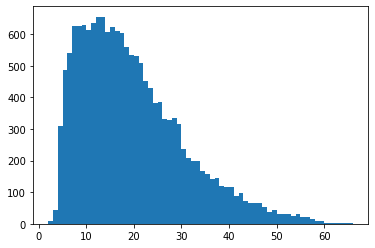

In [15]:
# checking the lengths of tweets
lengths=[len(t.split(" "))for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [16]:
# there are few tweets which are having 50 to 60 words

In [17]:
maxlen=50
# we are simply saying tweets having over 50 words we simply chop them or truncate them
# and tweets having less than 50 words we are pad those sequences with zeros
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [18]:
# Defining a function get_sequences for getting sequences for our different sets
def get_sequences(tokenizer, tweets):
  sequences=tokenizer.texts_to_sequences(tweets)
  padded=pad_sequences(sequences,truncating='post',padding='post',maxlen=maxlen)
  return padded

In [19]:
padded_train_seq=get_sequences(tokenizer,tweets)

In [20]:
padded_train_seq[1]

array([   2,   40,  101,   60,    8,   15,  494,    5,   15, 3496,  553,
         32,   60,   61,  128,  148,   76, 1480,    4,   22, 1255,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

# Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [21]:
# printing unique classes
classes=set(labels)
print(classes)

{'love', 'surprise', 'sadness', 'fear', 'joy', 'anger'}


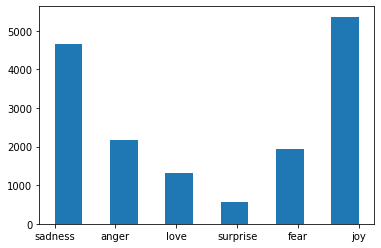

In [22]:
# plot the histogram
plt.hist(labels, bins=11)
plt.show()

In [23]:
# creating a couple of dictonaries to be able to convert a name of their classes to their corresponding numerical values
class_to_index=dict((c,i) for i,c in enumerate(classes))
index_to_class=dict((v,k) for k,v in class_to_index.items())

In [24]:
class_to_index

{'anger': 5, 'fear': 3, 'joy': 4, 'love': 0, 'sadness': 2, 'surprise': 1}

In [25]:
index_to_class

{0: 'love', 1: 'surprise', 2: 'sadness', 3: 'fear', 4: 'joy', 5: 'anger'}

In [26]:
names_to_ids=lambda labels:np.array([class_to_index.get(x) for x in labels])

In [27]:
train_labels=names_to_ids(labels)
print(train_labels[0])

2


# Creating the Model

1. Creating the model
2. Compiling the model

In [28]:
# creating the model
model=tf.keras.models.Sequential([
      tf.keras.layers.Embedding(10000,16,input_length=maxlen),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
      tf.keras.layers.Dense(6, activation='softmax')                            
])

model.compile(
    
    loss='sparse_categorical_crossentropy', #  we don't use one hot encoding so we are using sparse_categorical_entropy here 
    optimizer='adam',
    metrics=['accuracy']
)

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


# Training the Model

1. Preparing a validation set
2. Training the model

In [30]:
# preparing the validation set
val_tweets,val_labels=get_tweet(val)
val_seq=get_sequences(tokenizer,val_tweets)
val_labels=names_to_ids(val_labels) # encoding labels to numbers

In [31]:
val_tweets[0],val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 2)

In [32]:
# training the models
h=model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2)
# If model doesnt see any improvement in val_accuracy for over 2 epochs it stops the training
    ]
)

Epoch 1/20
500/500 [==============================] - 39s 58ms/step - loss: 1.3501 - accuracy: 0.4667 - val_loss: 0.8595 - val_accuracy: 0.7000
Epoch 2/20
500/500 [==============================] - 27s 55ms/step - loss: 0.5783 - accuracy: 0.8033 - val_loss: 0.5820 - val_accuracy: 0.8105
Epoch 3/20
500/500 [==============================] - 27s 55ms/step - loss: 0.3419 - accuracy: 0.8883 - val_loss: 0.4611 - val_accuracy: 0.8505
Epoch 4/20
500/500 [==============================] - 27s 55ms/step - loss: 0.2294 - accuracy: 0.9263 - val_loss: 0.4055 - val_accuracy: 0.8715
Epoch 5/20
500/500 [==============================] - 27s 55ms/step - loss: 0.1597 - accuracy: 0.9498 - val_loss: 0.3986 - val_accuracy: 0.8775
Epoch 6/20
500/500 [==============================] - 27s 55ms/step - loss: 0.1281 - accuracy: 0.9604 - val_loss: 0.3972 - val_accuracy: 0.8815
Epoch 7/20
500/500 [==============================] - 27s 55ms/step - loss: 0.1030 - accuracy: 0.9687 - val_loss: 0.4396 - val_accuracy:

#Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

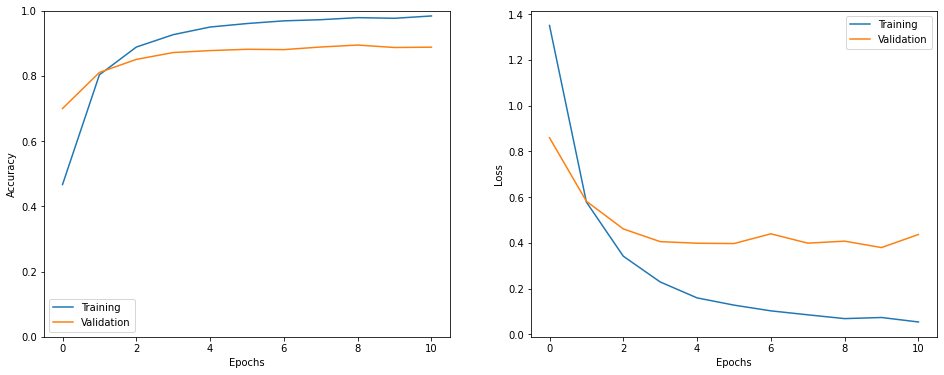

In [33]:
show_history(h)

In [34]:
test_tweets, test_labels=get_tweet(test)
test_seq=get_sequences(tokenizer, test_tweets)
test_labels=names_to_ids(test_labels)

In [35]:
_=model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 19ms/step - loss: 0.4627 - accuracy: 0.8745


In [36]:
i=random.randint(0, len(test_labels)-1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p=model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class=index_to_class[np.argmax(p).astype('uint8')] # get the predicted class

print('Predicted Emotion:', pred_class)


Sentence: i may not have really been feeling superior but i certainly was feeling that i had the answers wasnt i
Emotion: joy
Predicted Emotion: joy


In [37]:
# prediction for all the examples
preds=model.predict(test_seq)

In [38]:
np.argmax(preds[1])

2